In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nftoniotv2/NetFlow v2 Features.csv
/kaggle/input/nftoniotv2/NF-ToN-IoT-V2.parquet


In [2]:
from fastcore.basics import *
from fastcore.parallel import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from os import cpu_count
from math import floor
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
import shap
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
shap.initjs()

In [3]:
data=pd.read_parquet("/kaggle/input/nftoniotv2/NF-ToN-IoT-V2.parquet")

## very very Basic EDA

In [4]:
data.dtypes

L4_SRC_PORT                      int32
L4_DST_PORT                      int32
PROTOCOL                          int8
L7_PROTO                       float32
IN_BYTES                         int32
IN_PKTS                          int32
OUT_BYTES                        int32
OUT_PKTS                         int32
TCP_FLAGS                        int16
CLIENT_TCP_FLAGS                 int16
SERVER_TCP_FLAGS                 int16
FLOW_DURATION_MILLISECONDS       int32
DURATION_IN                      int32
DURATION_OUT                     int32
MIN_TTL                          int16
MAX_TTL                          int16
LONGEST_FLOW_PKT                 int32
SHORTEST_FLOW_PKT                int16
MIN_IP_PKT_LEN                   int16
MAX_IP_PKT_LEN                   int32
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int32
RETRANSMITTED_IN_PKTS            int16
RETRANSMITTED_OUT_BYTES          int32
RETRANSMITTED_OUT_PKTS   

In [5]:
data.drop(columns=["Attack"])

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
0,49235,4444,6,0.000000,155392,202,34552,149,24,24,...,95,45555,4805,0,0,0,0,0,0,1
1,49228,1880,6,0.000000,1600,40,35741,65,24,16,...,6,16425,237,0,0,0,0,0,0,0
2,0,0,1,0.000000,212,2,0,0,0,0,...,0,0,0,771,3,0,0,0,0,0
3,65317,1900,17,0.000000,165,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60766,15600,17,0.000000,63,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13135876,49200,4444,6,0.000000,152960,210,36392,163,24,24,...,79,16425,2385,0,0,0,0,0,0,1
13135877,1880,49178,6,0.000000,31067,49,1160,29,24,24,...,9,237,16425,0,0,0,0,0,0,0
13135878,43,37796,6,170.000000,4275,5,296,5,25,25,...,3,453,1024,19200,75,0,0,0,0,0
13135879,443,49198,6,91.178001,191,4,151,3,25,25,...,0,64240,63846,0,0,0,0,0,0,0


In [6]:
print(data.isnull().values.any())
print(data.isna().values.any())
np.isinf(data.drop(columns=["Attack"])).values.sum()

False
False


0

In [7]:
print(np.where(np.isnan(data.drop(columns=["Attack"]))))
print(np.where(np.isinf(data.drop(columns=["Attack"]))))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [8]:
# datatype float64 for every feature doesn't help 
# for col in data.columns[:-1]:
#     data[col]=data[col].astype("float64")

In [9]:
data.L7_PROTO=data.L7_PROTO.astype("float64")

In [10]:
idx=data['SRC_TO_DST_SECOND_BYTES'].sort_values(ascending=False).head(50).index

In [11]:
data.Label.value_counts()

1    9534597
0    3601284
Name: Label, dtype: int64

In [12]:
data.Attack.value_counts()

Benign        3601284
scanning      3002169
xss           2449955
ddos          1746590
password       993718
injection      660467
dos            654359
backdoor        16259
mitm             7723
ransomware       3357
Name: Attack, dtype: int64

In [13]:
data = data[data['SRC_TO_DST_SECOND_BYTES'] <= np.finfo(np.float32).max]
data = data[data['DST_TO_SRC_SECOND_BYTES'] <= np.finfo(np.float32).max]

In [14]:
# data['LG_SRC_TO_DST_SECOND_BYTES']=np.log(data['SRC_TO_DST_SECOND_BYTES']+1)
# data['LG_DST_TO_SRC_SECOND_BYTES']=np.log(data['DST_TO_SRC_SECOND_BYTES']+1)

In [15]:
# data=data.drop(columns=['L4_SRC_PORT', 'L4_DST_PORT','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES']) #dropping metadata
data=data.drop(columns=['L4_SRC_PORT', 'L4_DST_PORT']) #dropping metadata

In [16]:
data.dtypes

PROTOCOL                          int8
L7_PROTO                       float64
IN_BYTES                         int32
IN_PKTS                          int32
OUT_BYTES                        int32
OUT_PKTS                         int32
TCP_FLAGS                        int16
CLIENT_TCP_FLAGS                 int16
SERVER_TCP_FLAGS                 int16
FLOW_DURATION_MILLISECONDS       int32
DURATION_IN                      int32
DURATION_OUT                     int32
MIN_TTL                          int16
MAX_TTL                          int16
LONGEST_FLOW_PKT                 int32
SHORTEST_FLOW_PKT                int16
MIN_IP_PKT_LEN                   int16
MAX_IP_PKT_LEN                   int32
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int32
RETRANSMITTED_IN_PKTS            int16
RETRANSMITTED_OUT_BYTES          int32
RETRANSMITTED_OUT_PKTS           int16
SRC_TO_DST_AVG_THROUGHPUT        int64
DST_TO_SRC_AVG_THROUGHPUT

## Finding contaminant features using XAI (SHAP)
goal: 
- try to find the contaminant features that have blanked predictive power across all attack classes

method:
* look for shap values per feature that are consistantly high or low among all attack classes.
   
how:
```
possible_contaminants =[]
    while models can achive high accuracy{
    
        * Train a binary classification model (e.g., xgboost) on different attack classes and benign class
        * For each model, calculate shappley values on test set
        * For each model, use np.abs(shap_values).mean(0) to compute the mean absolute SHAP value for each feature across all samples. 
          This will give you a measure of how much each feature contributes to the model output on average across all samples (the importance).
          
        * normalize importances across for each attack class sum of feature importances equals 1
        * for each feature, calculate variance of importance for each attack class
        * for each feature, calculate average importance across all attack classes
        * score of a feature is the weighted sum of the importance and variance
        
        * feature F is feature with the highest score
        * possible_contaminants.append(F)
        * drop F from dataset
    }
```

In [17]:
training_set = data.sample(frac=0.1, replace=False,random_state=42)
# 10%train, 90% test
testing_set = data.drop(index=training_set.index)

In [18]:
training_set.Attack.value_counts()

Benign        359751
scanning      300838
xss           245020
ddos          174377
password       98996
injection      66318
dos            65570
backdoor        1605
mitm             758
ransomware       342
Name: Attack, dtype: int64

In [19]:
attacks=training_set.Attack.unique()
attacks=[ 'Benign','ddos', 'dos', 'scanning', 'xss', 'injection',
       'password', 'mitm', 'backdoor', 'ransomware']
attacks

['Benign',
 'ddos',
 'dos',
 'scanning',
 'xss',
 'injection',
 'password',
 'mitm',
 'backdoor',
 'ransomware']

### Correlated features

In [20]:
corr = training_set.corr()
corr_features={corr.columns[i] : corr.columns[(corr>0.9).iloc[i]].values.tolist() for i in range(0,corr.shape[0])}
corr_list=[]
for key,value in corr_features.items():
#     check if we already have this set
    have_set=False
    for set_s in corr_list:
        if key in set_s:
#             we have found a set
            have_set=True
            break
    if have_set==False and len(value)>1:
        corr_list.append(value)

In [21]:
corr_list

[['OUT_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES'],
 ['TCP_FLAGS', 'SERVER_TCP_FLAGS'],
 ['DURATION_IN', 'DURATION_OUT'],
 ['MIN_TTL', 'MAX_TTL'],
 ['LONGEST_FLOW_PKT', 'MAX_IP_PKT_LEN'],
 ['RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS'],
 ['RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS'],
 ['ICMP_TYPE', 'ICMP_IPV4_TYPE']]

In [22]:
#dropping all but one feature per correlation group
for i in range(len(corr_list)):
    training_set.drop(columns=corr_list[i][1:],inplace=True)
    testing_set.drop(columns=corr_list[i][1:],inplace=True)

### split into dataframes per attack class

In [23]:
training_set.Attack.value_counts()

Benign        359751
scanning      300838
xss           245020
ddos          174377
password       98996
injection      66318
dos            65570
backdoor        1605
mitm             758
ransomware       342
Name: Attack, dtype: int64

In [24]:
grouped = training_set.groupby(training_set.Attack)
dfs={cat:grouped.get_group(cat) for cat in attacks[1:]}
dfs[attacks[0]]=grouped.get_group(attacks[0]) #don't subsample normal attacks
#dfs key=attack_cat, value is dataframe

In [25]:
# to make calculations faster
for k,v in dfs.items():
    if v.shape[0]>10000:
        dfs[k]=v.sample(10000,replace=False)

In [26]:
# dfs["ddos"].dtypes

In [27]:
for atk_type in attacks[1:]:
    normals_to_sample = dfs[atk_type].shape[0]
#     print(normals_to_sample)
    normals_sample = dfs['Benign'].sample(normals_to_sample)
#     dfs['Normal'] = dfs['Normal'].drop(index=normals_sample.index)#don't resample
    dfs[atk_type] = pd.concat(objs=[dfs[atk_type], normals_sample])
    print(dfs[atk_type].shape[0], normals_sample.shape[0], dfs['Benign'].shape[0])

20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
1516 758 10000
3210 1605 10000
684 342 10000


In [28]:
testing_dfs = {}
grouped = testing_set.groupby(testing_set.Attack)
testing_dfs={cat:grouped.get_group(cat) for cat in attacks[1:]}
testing_dfs[attacks[0]]=grouped.get_group(attacks[0]) #don't subsample normal attacks
#testing_dfs key=attack_cat, value is dataframe 

In [29]:
#to make calculations faster
for k,v in testing_dfs.items():
    if v.shape[0]>10000:
        testing_dfs[k]=v.sample(10000,replace=False)

In [30]:
for atk_type in attacks[1:]:
    normals_to_sample = testing_dfs[atk_type].shape[0] 
    normals_sample = testing_dfs['Benign'].sample(normals_to_sample)
#     testing_dfs['Normal'] = testing_dfs['Normal'].drop(index=normals_sample.index)#don't resample
    testing_dfs[atk_type] = pd.concat(objs=[testing_dfs[atk_type], normals_sample])
    print(testing_dfs[atk_type].shape[0], normals_sample.shape[0], testing_dfs['Benign'].shape[0])

20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
13848 6924 10000
20000 10000 10000
6030 3015 10000


In [31]:
print(f"TRAINING SETS")
for k,v in dfs.items():
    v.drop(columns=['Attack'], inplace=True)
    print(k, v.shape)
    print(v['Label'].value_counts())

TRAINING SETS
ddos (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
dos (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
scanning (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
xss (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
injection (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
password (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
mitm (1516, 32)
1    758
0    758
Name: Label, dtype: int64
backdoor (3210, 32)
1    1605
0    1605
Name: Label, dtype: int64
ransomware (684, 32)
1    342
0    342
Name: Label, dtype: int64
Benign (10000, 32)
0    10000
Name: Label, dtype: int64


In [32]:
print("TESTING SETS")
for k,v in testing_dfs.items():
    v.drop(columns=['Attack'], inplace=True)   
    print(k, v.shape)
    print(v['Label'].value_counts())

TESTING SETS
ddos (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
dos (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
scanning (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
xss (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
injection (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
password (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
mitm (13848, 32)
1    6924
0    6924
Name: Label, dtype: int64
backdoor (20000, 32)
1    10000
0    10000
Name: Label, dtype: int64
ransomware (6030, 32)
1    3015
0    3015
Name: Label, dtype: int64
Benign (10000, 32)
0    10000
Name: Label, dtype: int64


In [33]:
training_dfs=dfs

In [34]:
print(np.where(np.isnan(training_dfs["ddos"])))
print(np.where(np.isinf(training_dfs["ddos"])))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


ITERATION: 0
['ddos', 0.994, 0.0, 0.994, 0.001, 0.994, 0.001]
['dos', 0.993, 0.0, 0.991, 0.001, 0.995, 0.0]
['scanning', 0.981, 0.003, 0.985, 0.002, 0.977, 0.006]
['xss', 0.993, 0.0, 0.991, 0.0, 0.995, 0.001]
['injection', 0.991, 0.001, 0.988, 0.001, 0.993, 0.001]
['password', 0.994, 0.001, 0.996, 0.0, 0.992, 0.001]
['mitm', 0.971, 0.002, 0.966, 0.003, 0.975, 0.001]
['backdoor', 0.996, 0.0, 0.999, 0.0, 0.993, 0.0]
['ransomware', 0.979, 0.003, 0.983, 0.005, 0.976, 0.003]
top features ['TCP_WIN_MAX_IN', 'SRC_TO_DST_AVG_THROUGHPUT', 'LONGEST_FLOW_PKT']
top importances [0.12393234 0.0626632  0.05927194]
 feature to be dropped: TCP_WIN_MAX_IN
 correlated features: []
ITERATION: 1
['ddos', 0.994, 0.0, 0.994, 0.0, 0.994, 0.001]
['dos', 0.993, 0.0, 0.991, 0.001, 0.995, 0.0]
['scanning', 0.982, 0.001, 0.984, 0.001, 0.98, 0.001]
['xss', 0.991, 0.0, 0.989, 0.001, 0.994, 0.001]
['injection', 0.989, 0.001, 0.985, 0.001, 0.992, 0.001]
['password', 0.994, 0.001, 0.995, 0.001, 0.992, 0.001]
['mitm', 0

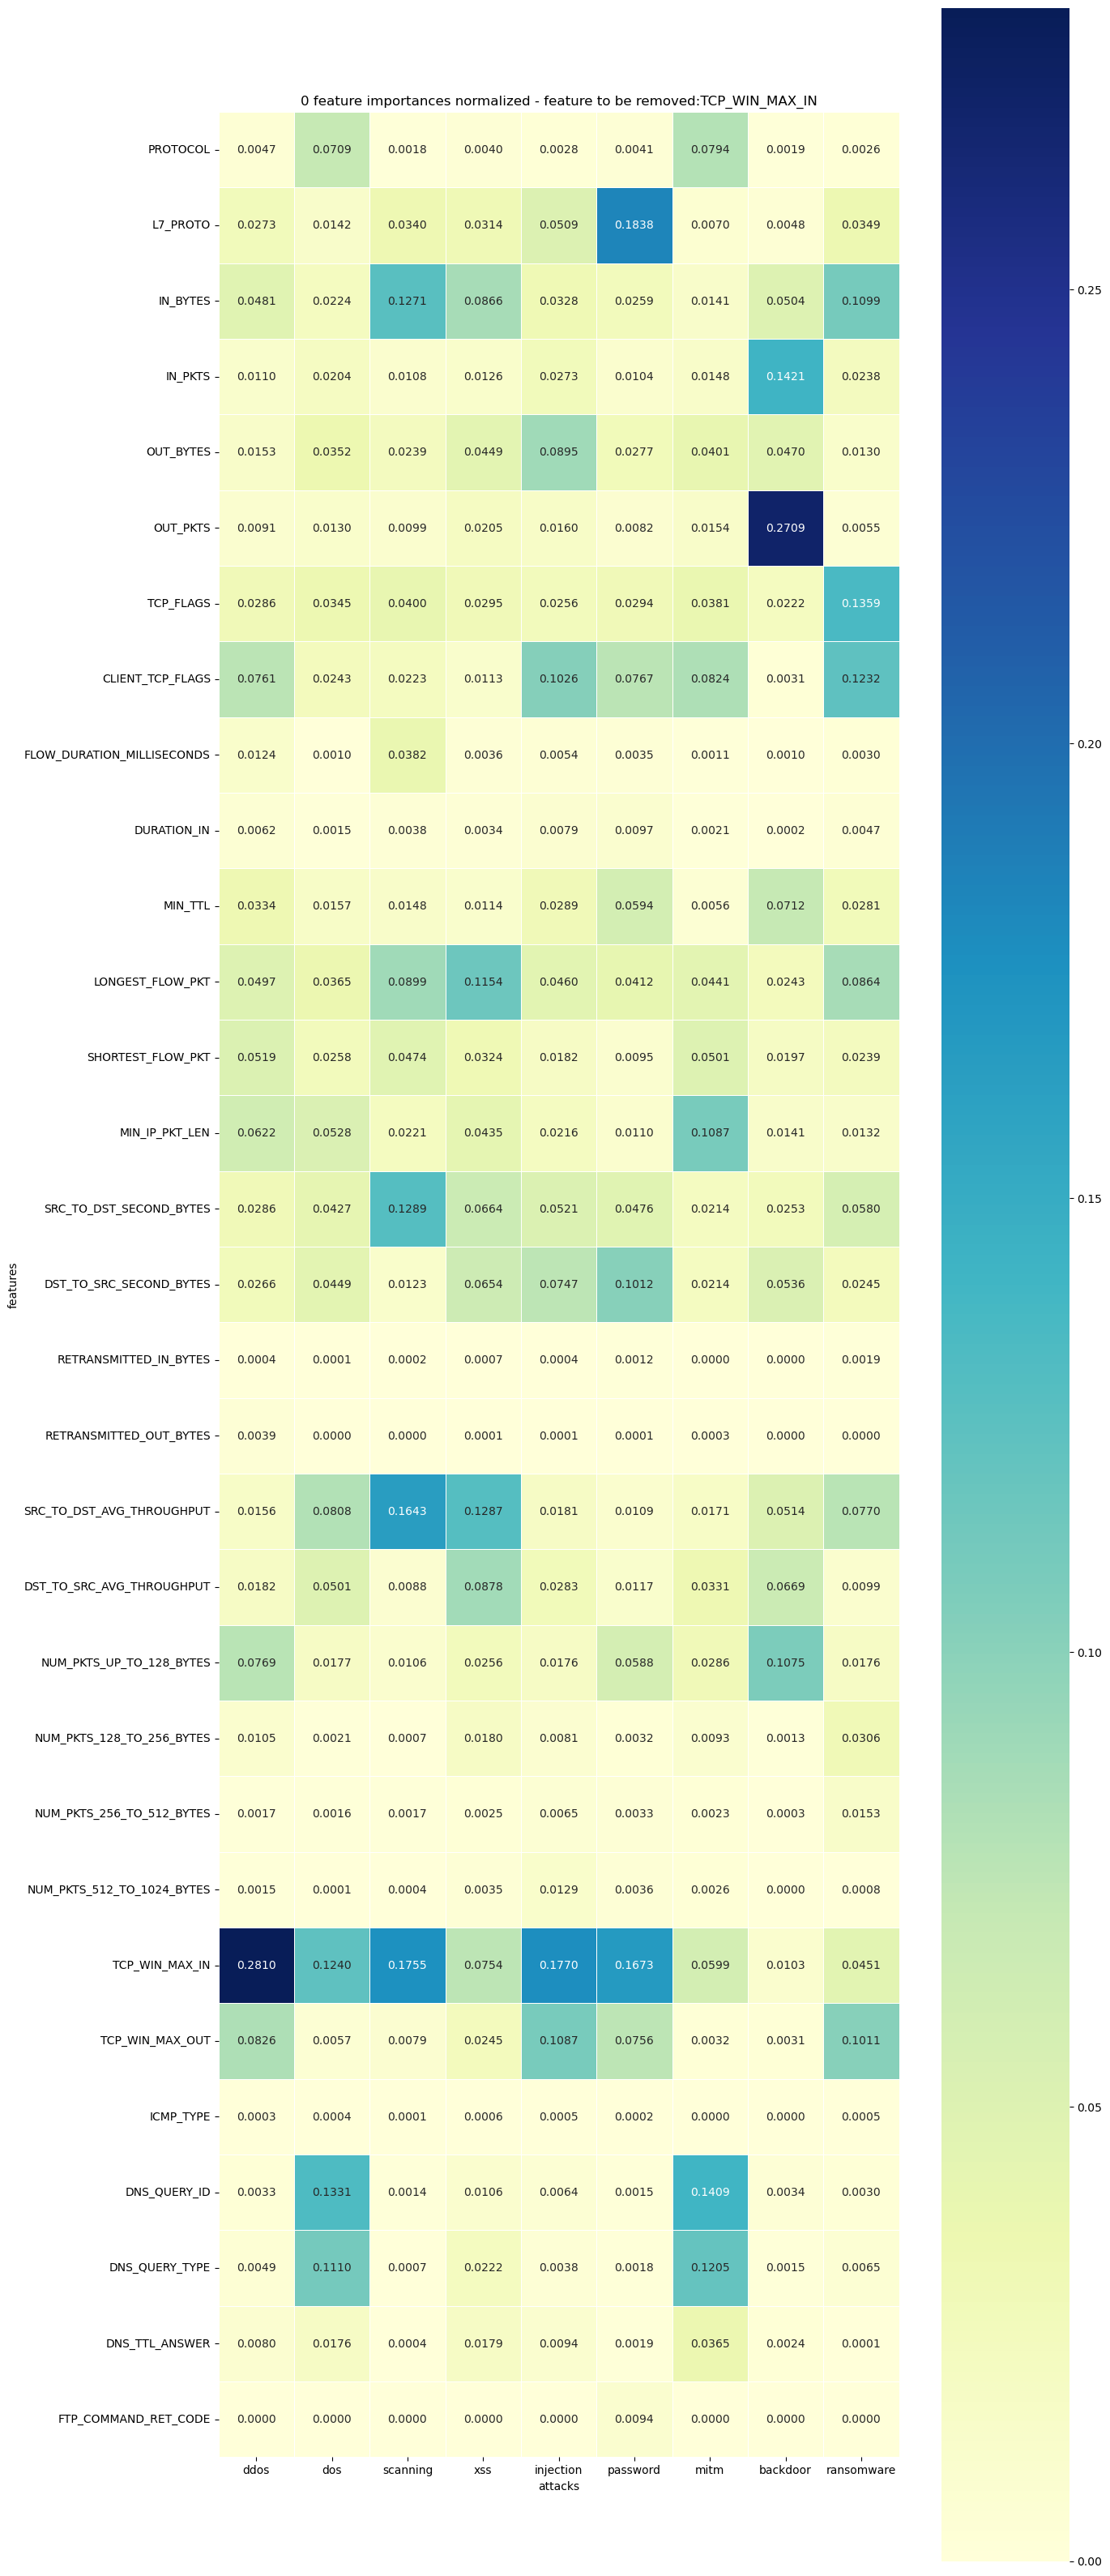

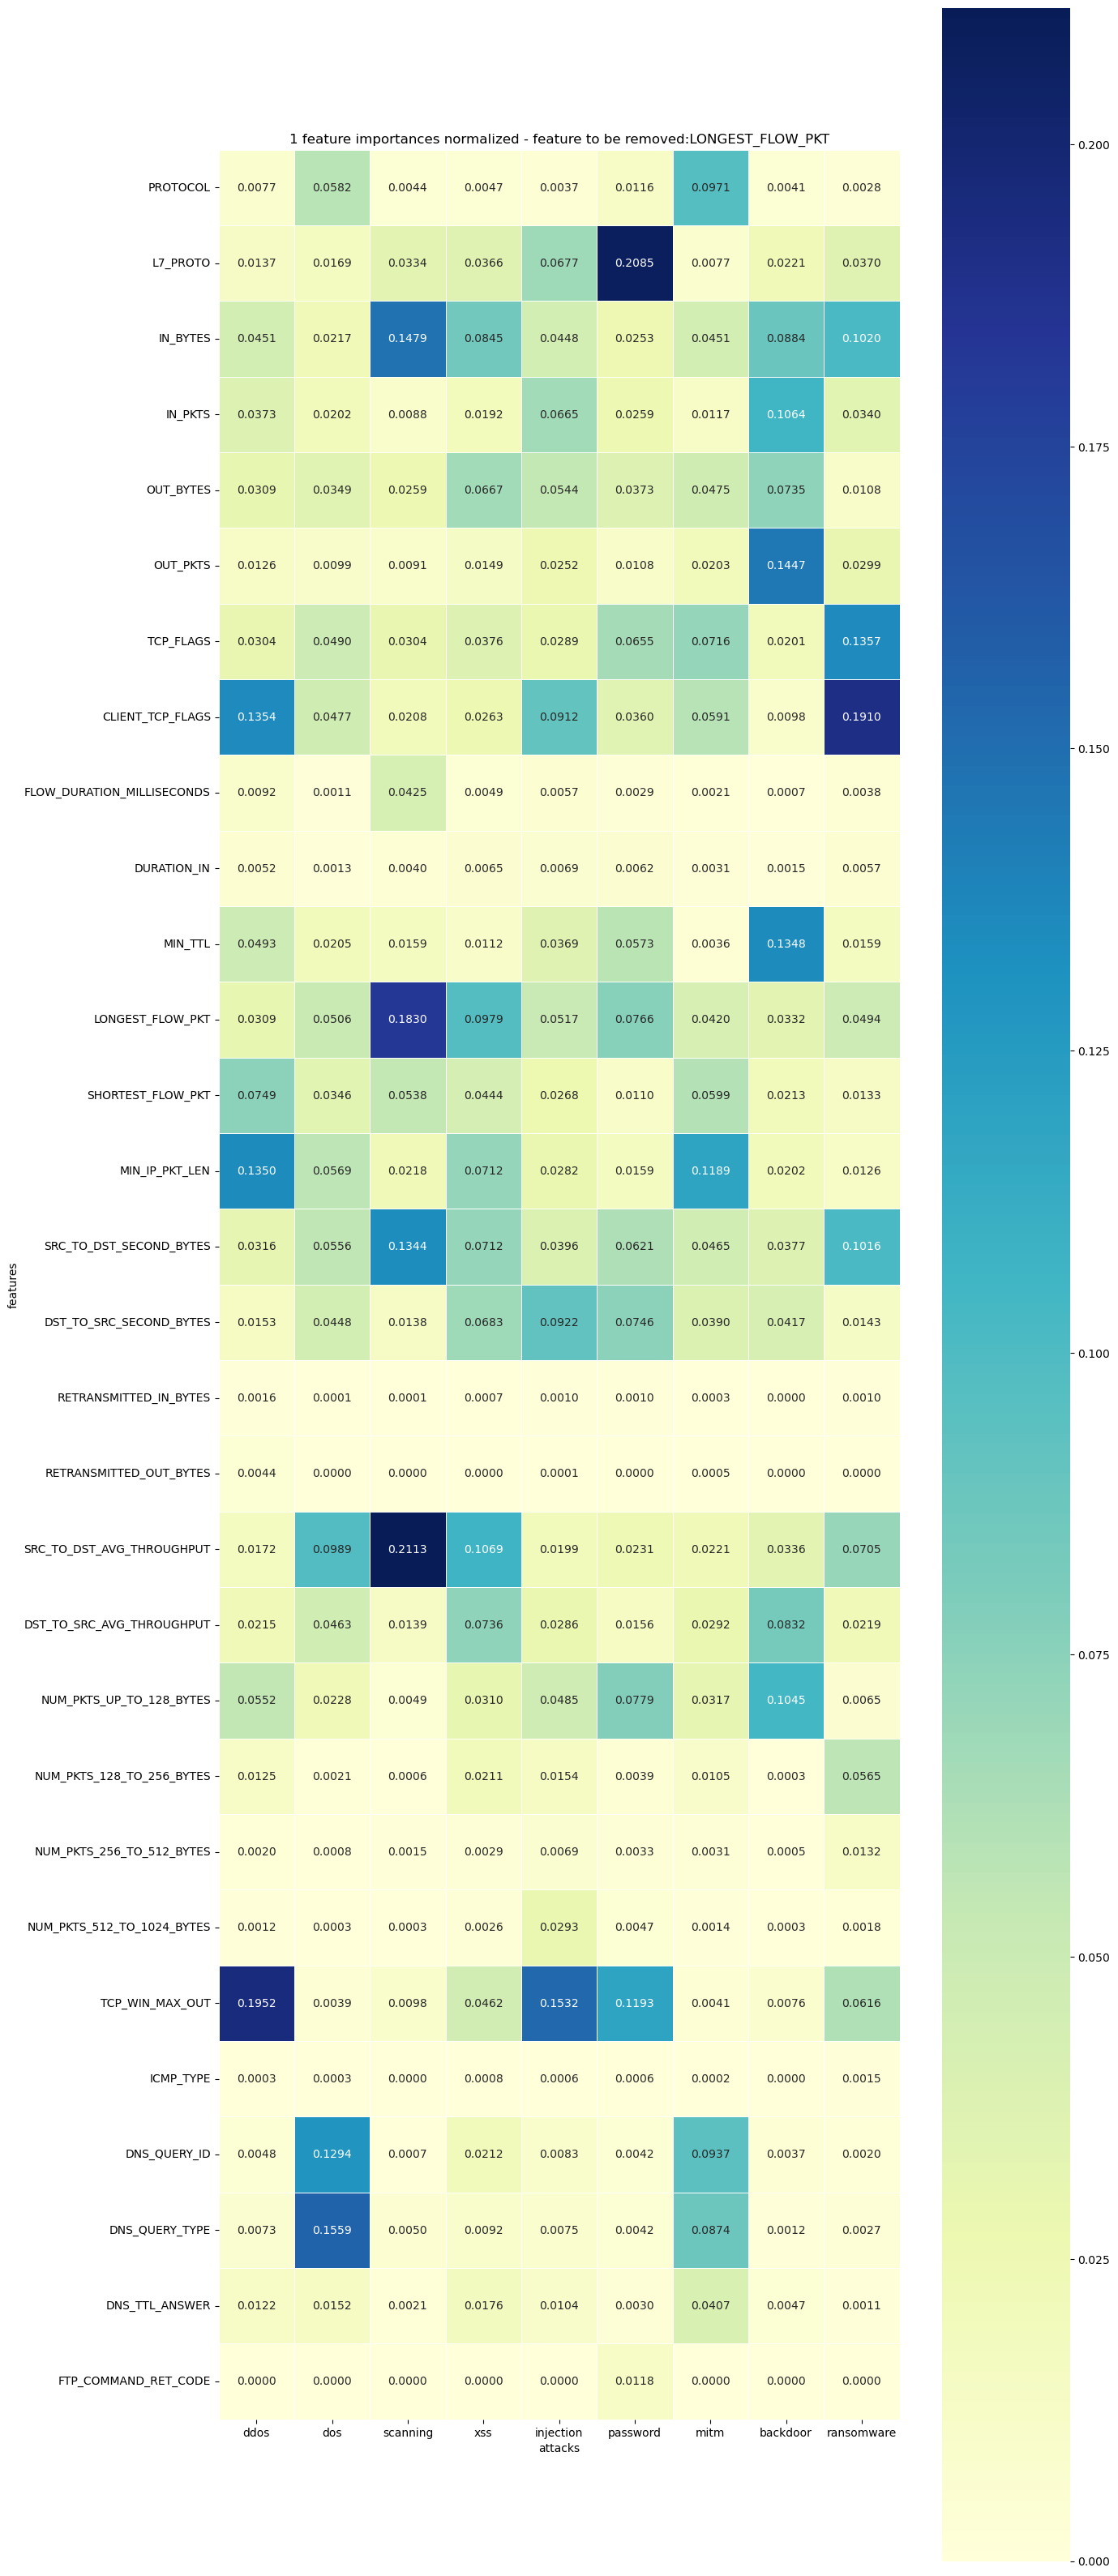

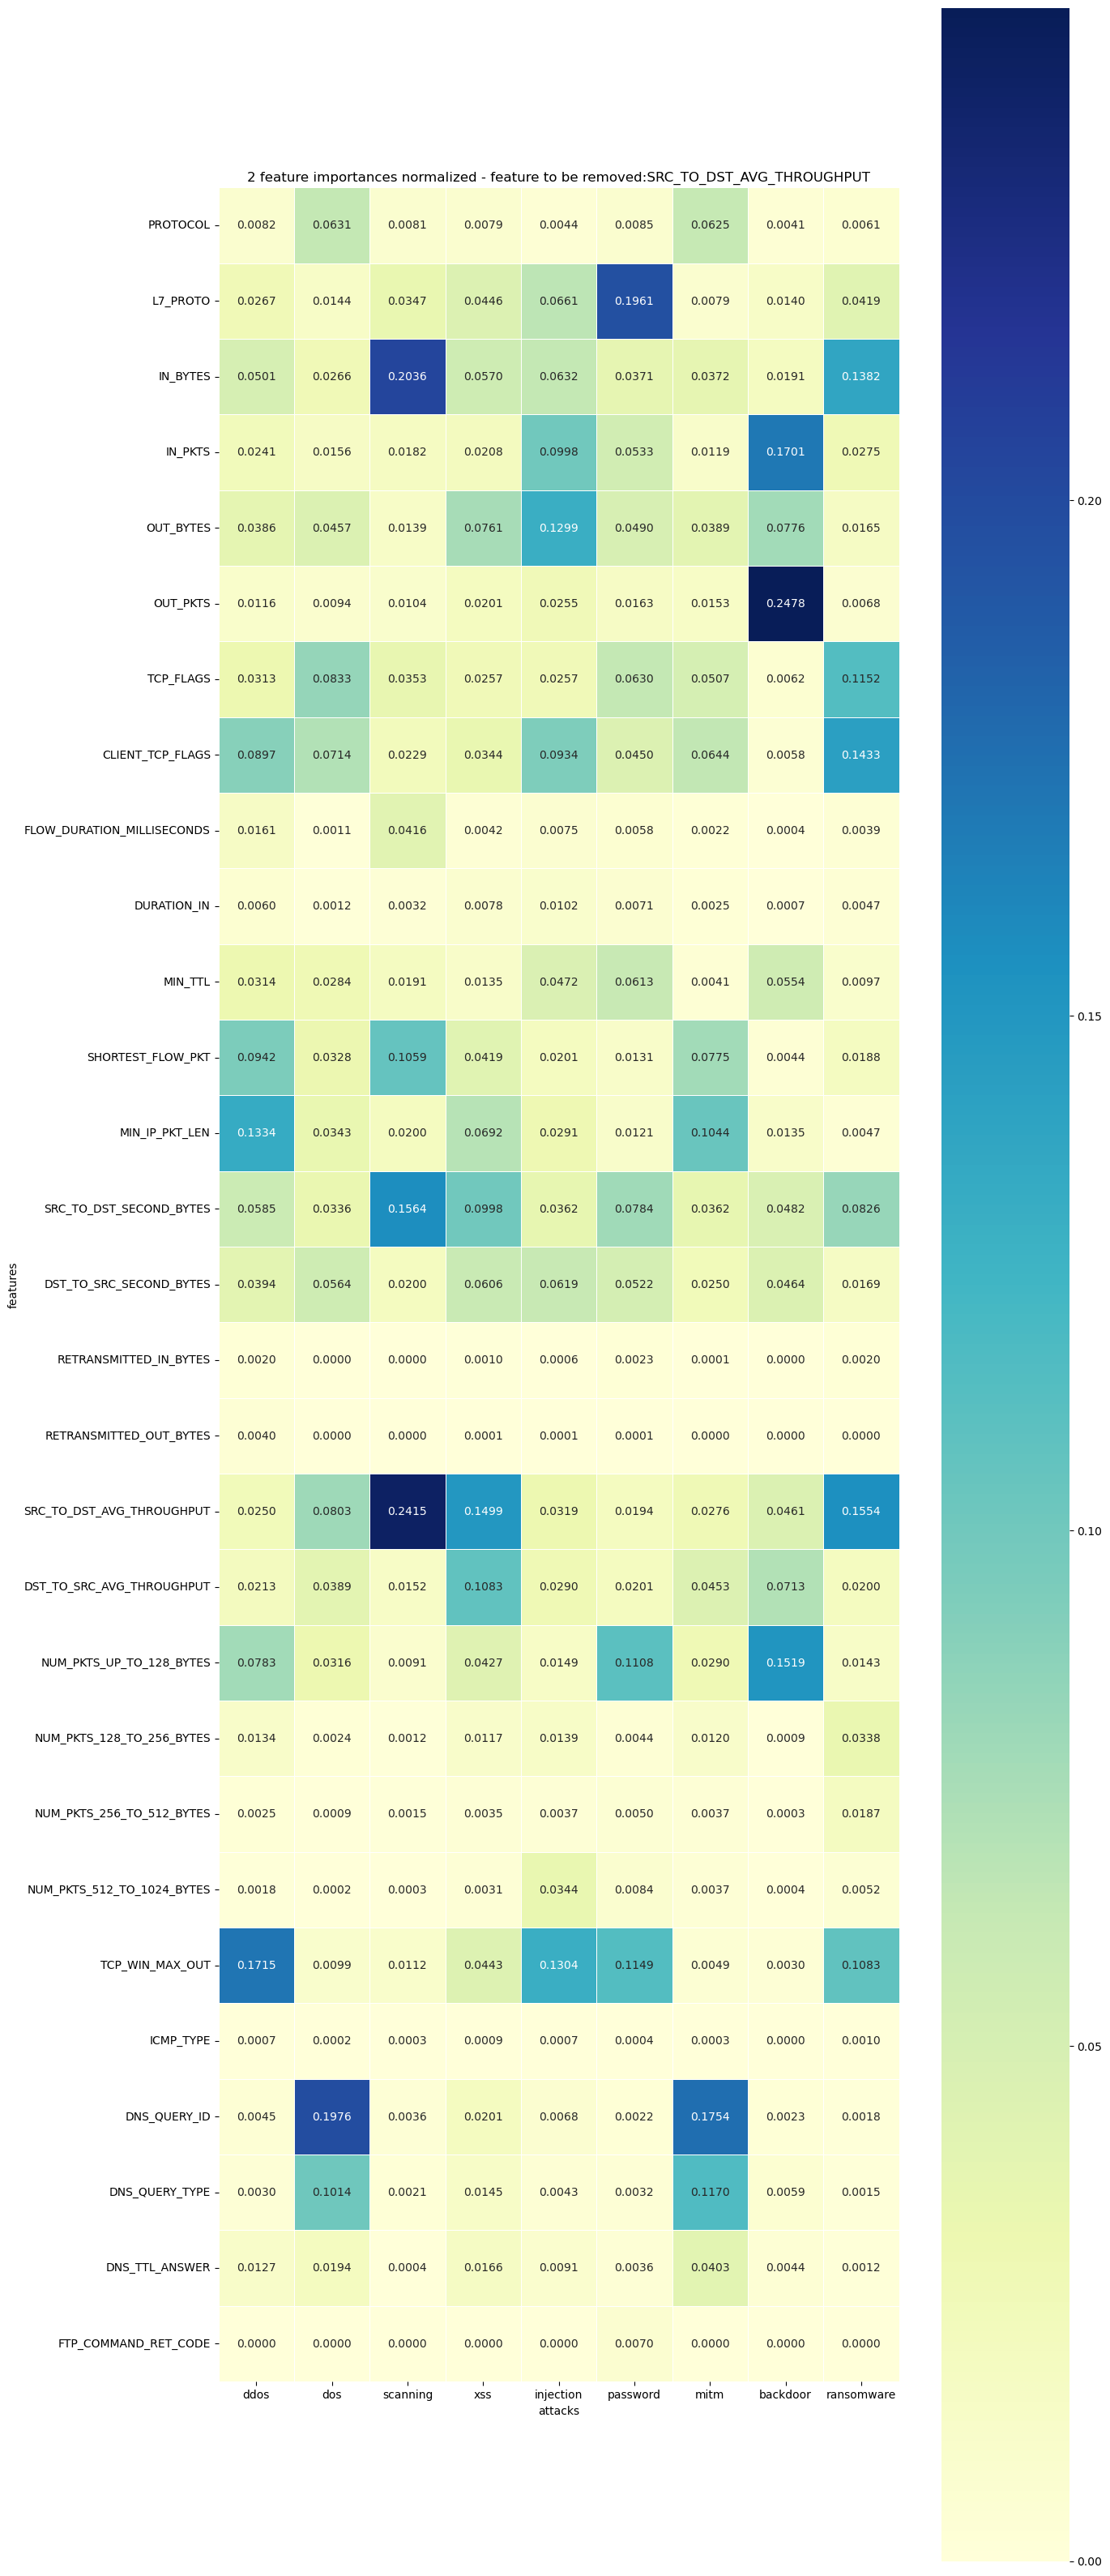

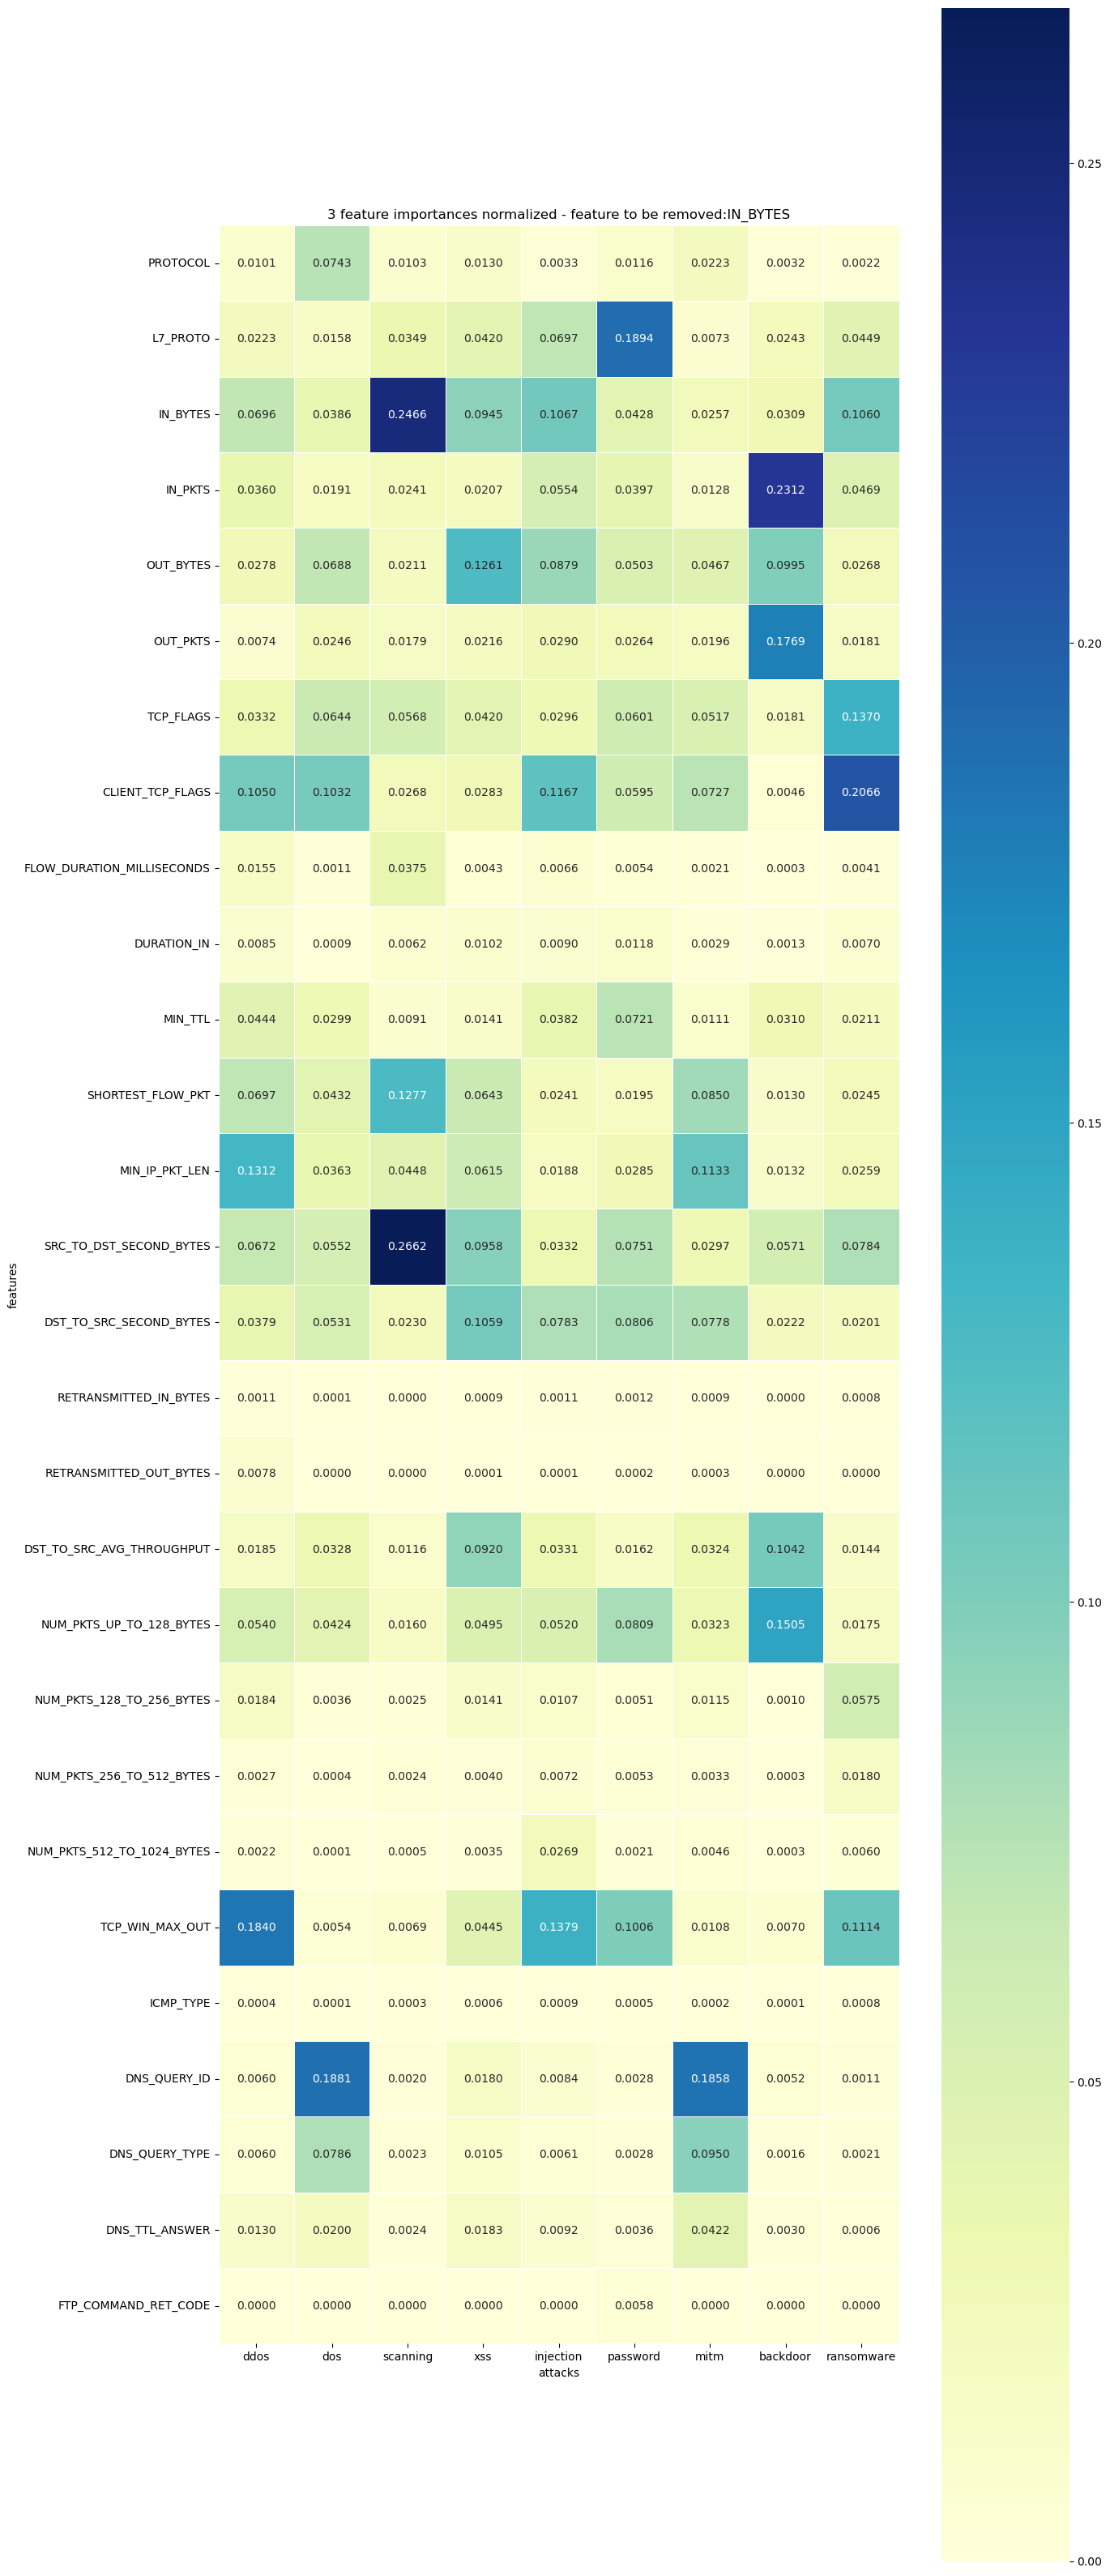

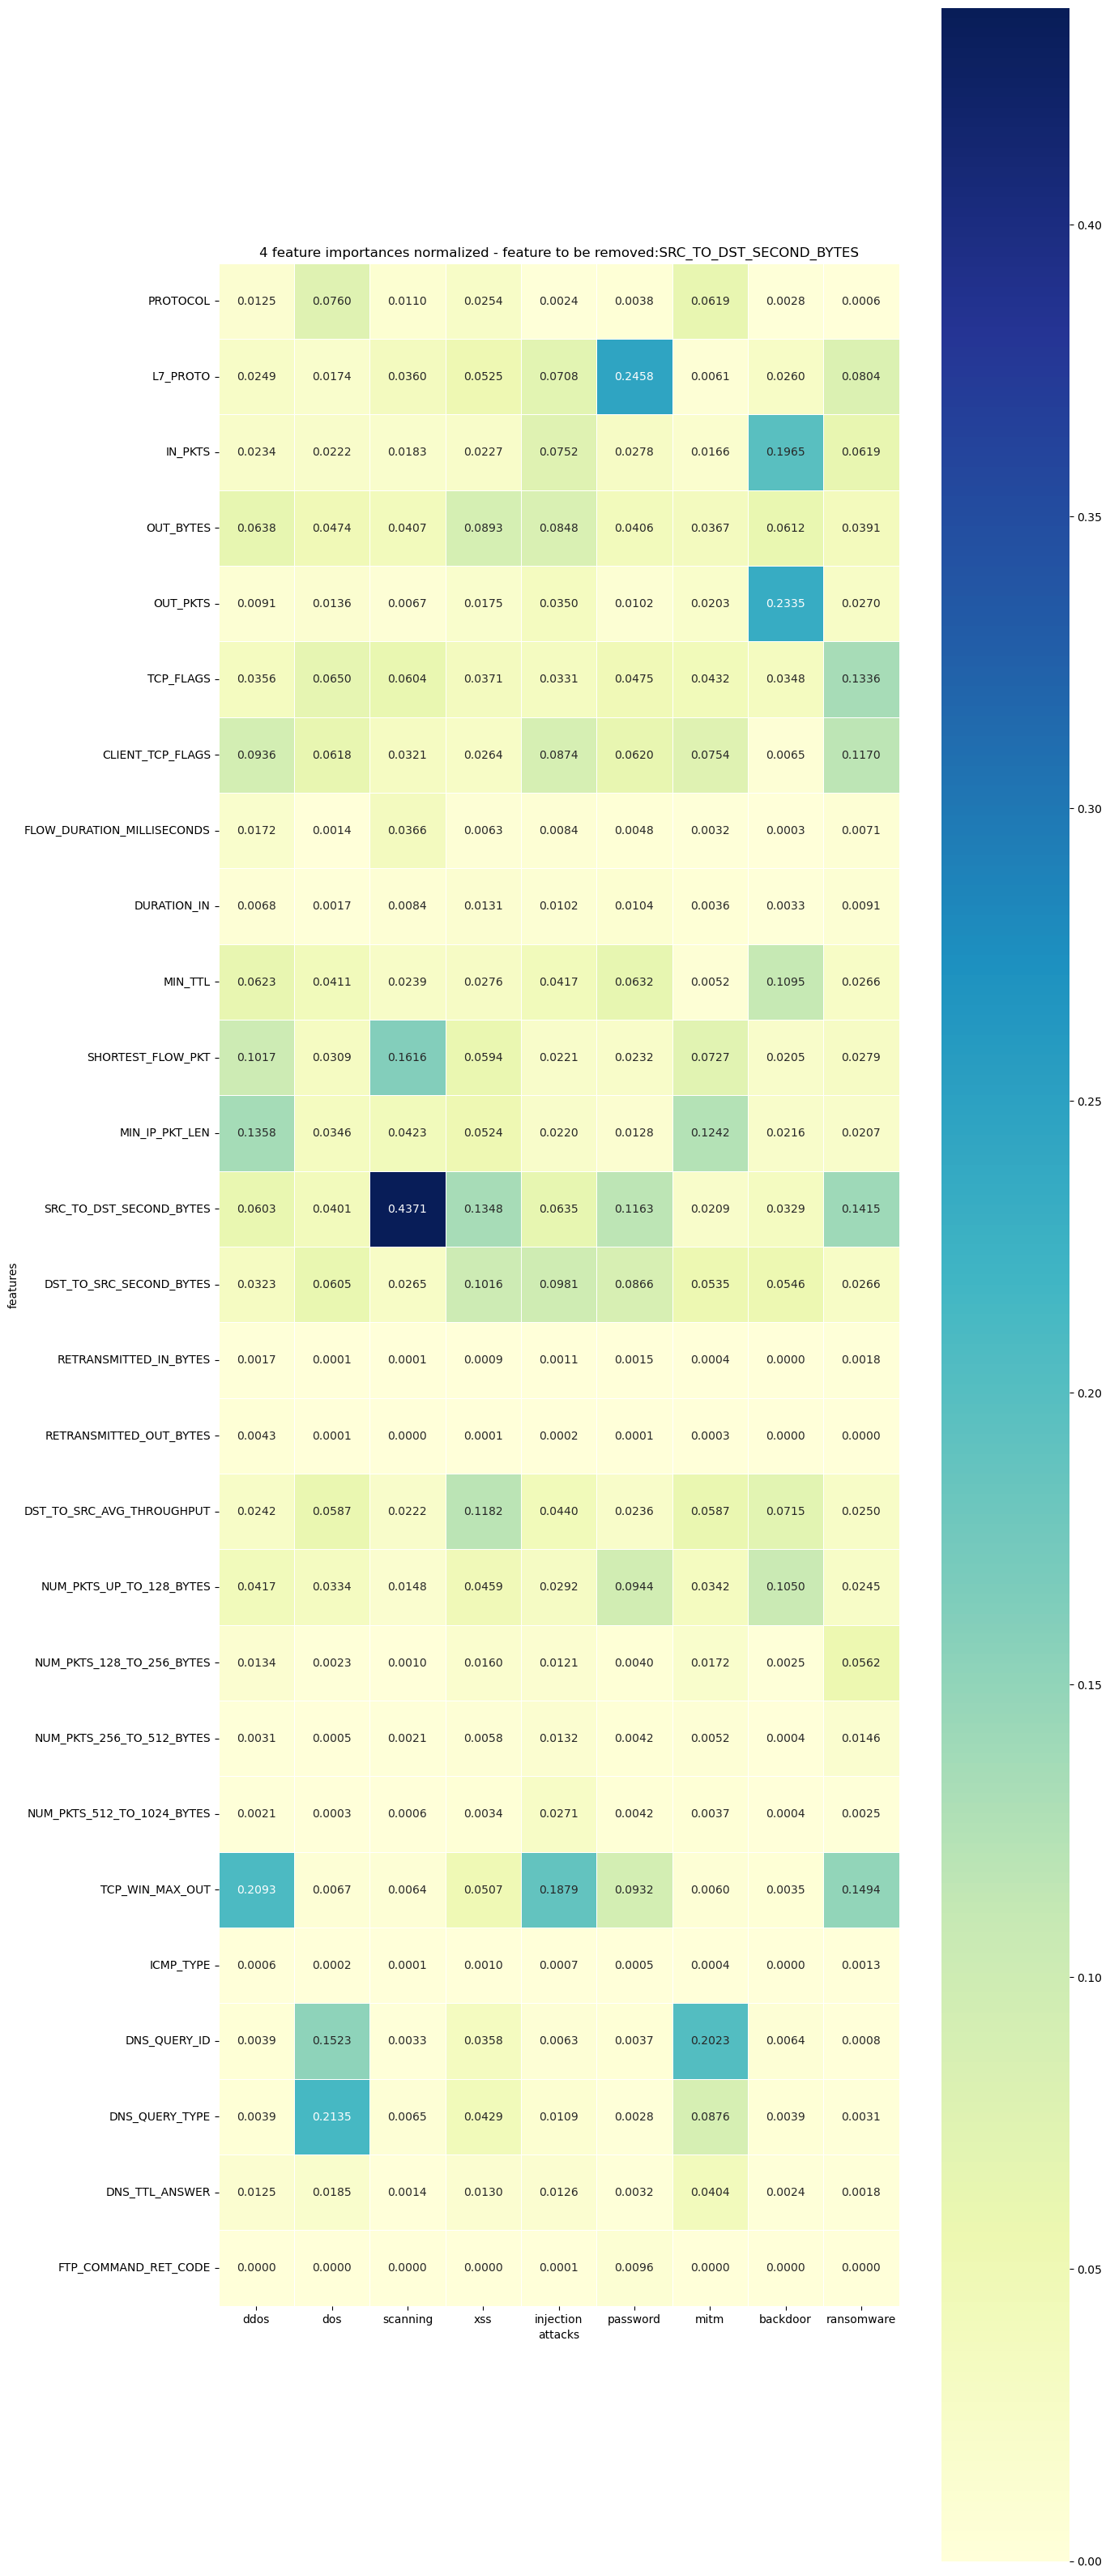

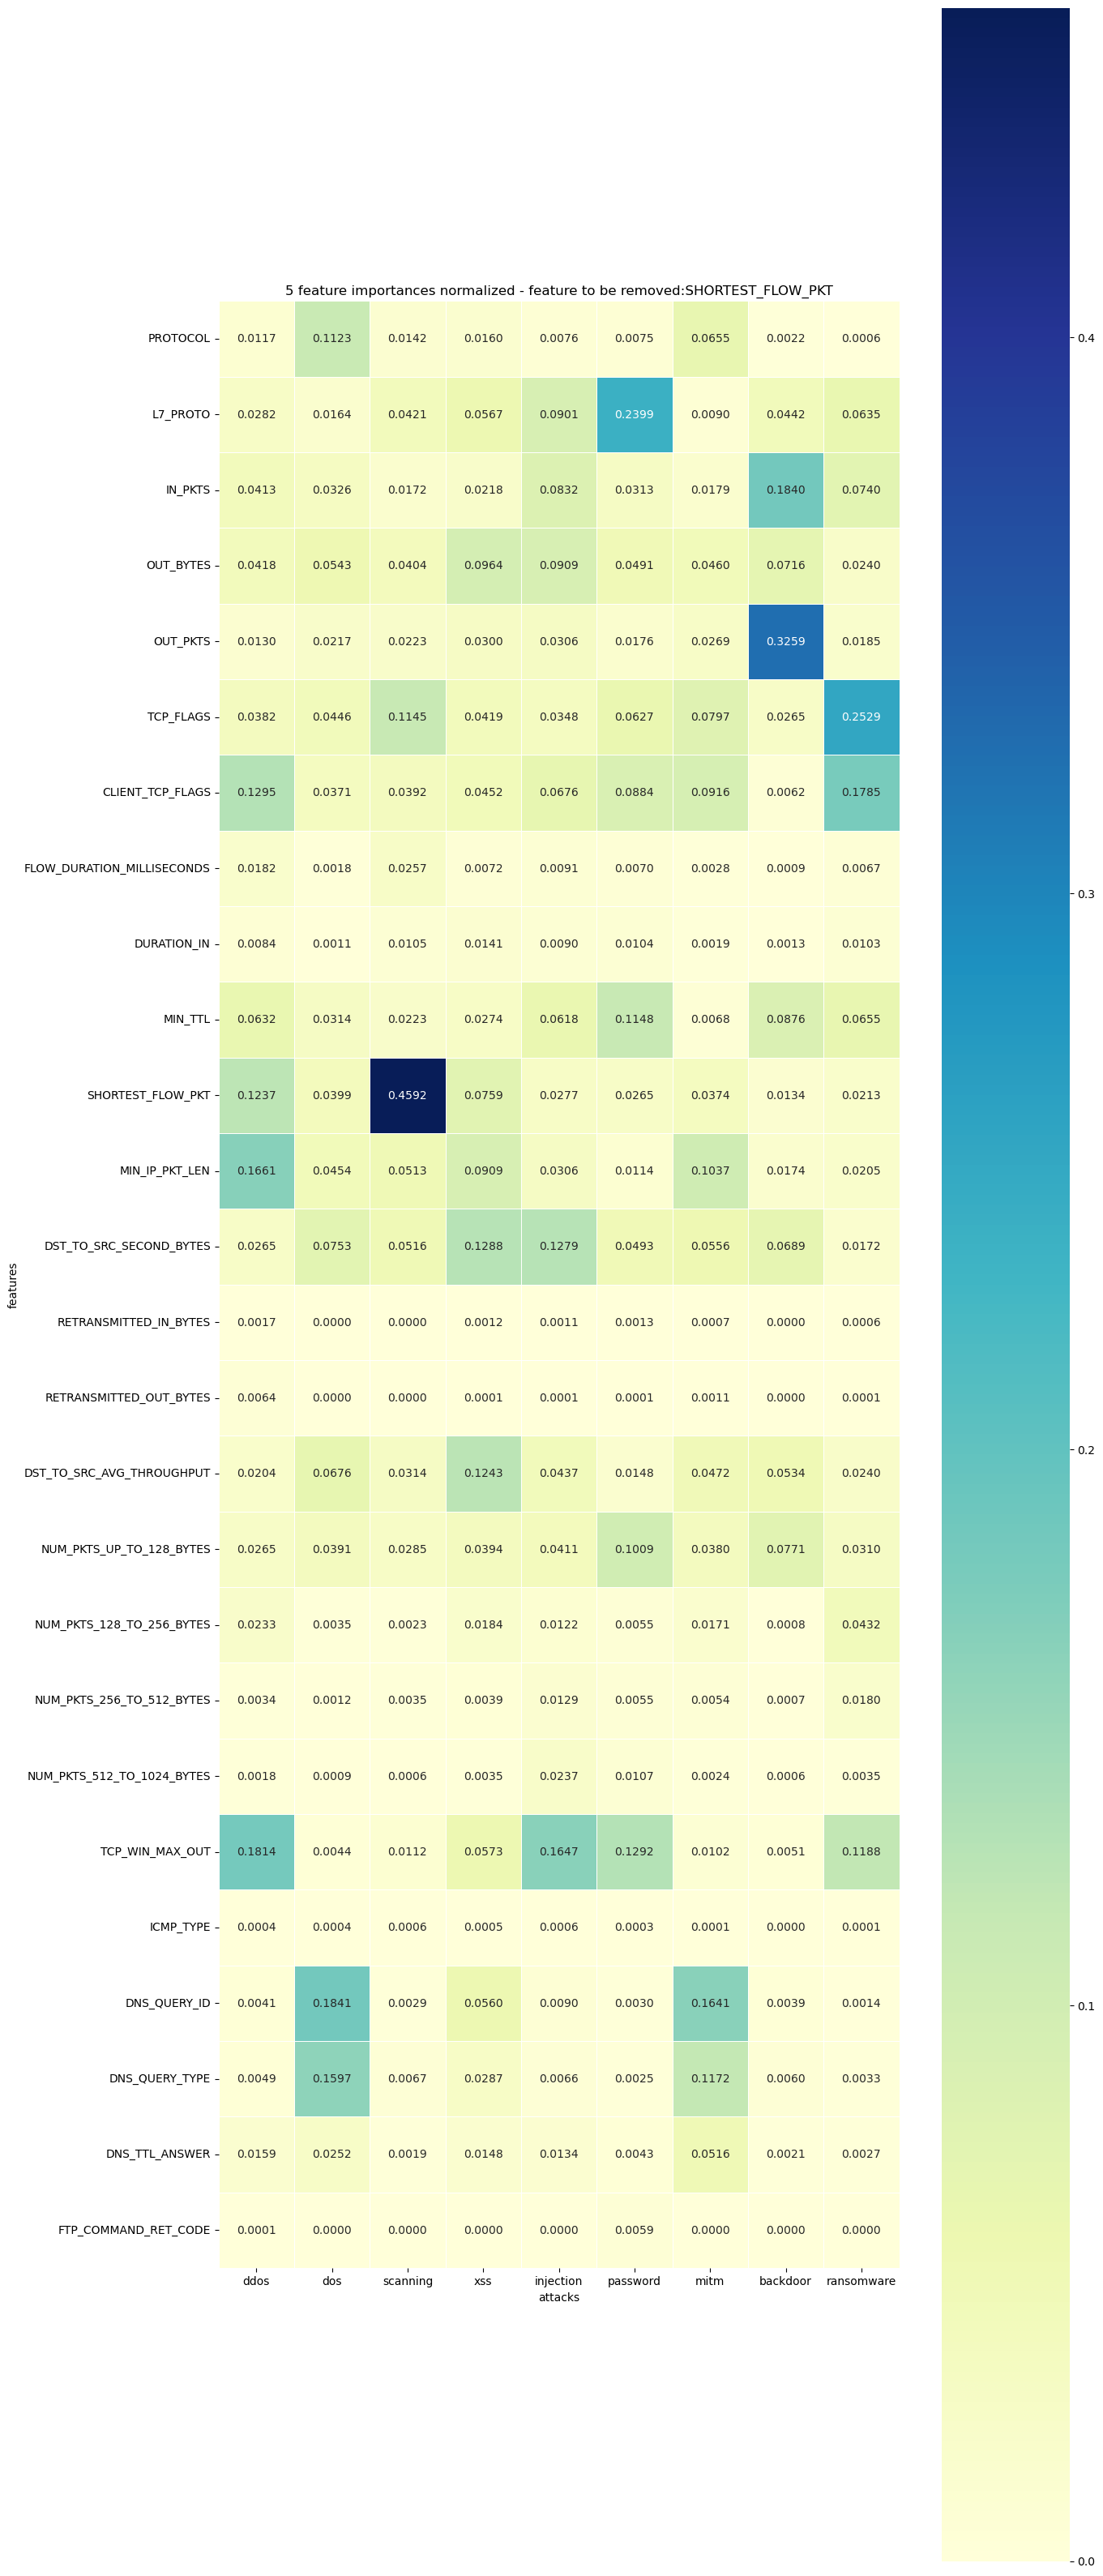

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

weight=0.5
iteration=0
possible_contaminants=[]
while True: #break when 1 of the models has a score lower than 0.8
    print(f"ITERATION: {iteration}")
#     -----------------Train Models-------------------------------
    prepared_result_rows = [] 
    for src_atk_type in attacks[1:]:
        dst_atk_type=src_atk_type
        accuracies = []
        precisions = []
        recalls = []
        importances=[]
        # zs = StandardScaler()
    #     oe=OrdinalEncoder()
        X_train = training_dfs[src_atk_type][training_dfs[src_atk_type].columns[:-1]]
    #     X_train[good_label_cols]=oe.fit_transform(X_train[good_label_cols])
        # X_train = zs.fit_transform(X_train.array.reshape(-1,1))
        y_train = training_dfs[src_atk_type][training_dfs[src_atk_type].columns[-1]]

        X_test = testing_dfs[dst_atk_type][testing_dfs[dst_atk_type].columns[:-1]]
    #     X_test[good_label_cols]=oe.transform(X_test[good_label_cols])

        # X_test = zs.transform(X_test.array.reshape(-1,1))
        y_test = testing_dfs[dst_atk_type][testing_dfs[dst_atk_type].columns[-1]]
        
        # doesn't help
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)
#         X_train=X_train.reset_index()
#         X_test=X_test.reset_index()
#         y_train=y_train.reset_index()
#         y_test=y_test.reset_index()
        
        for i in range(6):
            clf=RandomForestClassifier()
            params = {
                                'bootstrap': True,
                                'max_features': 'sqrt',
                                'min_impurity_decrease': 0.0,
                                'min_samples_leaf': 2,
                                'n_estimators': 10,
                                'max_samples': 0.5,
                                'criterion': 'entropy',
                                'n_jobs': -1,
                                }
            clf.set_params(**params)
            clf.fit(X=X_train, y=y_train)

            outputs = clf.predict(X=X_test)
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_test)

            importances.append(np.abs(shap_values[1]).mean(axis=0))
            accuracies.append(accuracy_score(y_true=y_test, y_pred=outputs))
            precisions.append(precision_score(y_true=y_test, y_pred=outputs, zero_division=0))
            recalls.append(recall_score(y_true=y_test, y_pred=outputs, zero_division=0))
        prepared_result_row = [
                        src_atk_type,
                        np.mean(importances,axis=0),
                        round(np.mean(accuracies), 3),
                        round(np.std(accuracies), 3),
                        round(np.mean(precisions), 3),
                        round(np.std(precisions), 3),
                        round(np.mean(recalls), 3),
                        round(np.std(recalls), 3),            
        ]
        print([prepared_result_row[0]]+prepared_result_row[2:])
        prepared_result_rows.append(prepared_result_row)
#   -----------------------Analyze Results -------------------------------
    #check if we can continue
    scores=[row[2] for row in prepared_result_rows]
    if any(x < 0.8 for x in scores):
        break

    #normalize importances
    stacked_array_norm = np.stack([row[1]/row[1].sum() for row in prepared_result_rows], axis=1)
    
    #average over all attack classes
    importances=stacked_array_norm.mean(axis=1)
    
    variance=stacked_array_norm.var(axis=1)
    #get the most important (weighted by variance) feature
    weighted_importances=(1-weight)*importances+(weight)*(0.25-variance)
    sorted_indices = np.argsort(weighted_importances)[::-1]
    sorted_labels = [X_test.columns[i] for i in sorted_indices]
    sorted_importances = importances[sorted_indices]
    print(f"top features {sorted_labels[:3]}")
    print(f"top importances {sorted_importances[:3]}")
    print(f" feature to be dropped: {sorted_labels[0]}")
    print(f" correlated features: {[feature_group for feature_group in corr_list if sorted_labels[0] in feature_group]}")
    possible_contaminants.append(sorted_labels[0])
    possible_contaminants+=[feature_group for feature_group in corr_list if sorted_labels[0] in feature_group]
    #create figure
    fig, ax = plt.subplots(figsize=(15, 50))

    # create heatmap with annotations
    sns.heatmap(stacked_array_norm, annot=True, fmt='.4f', cmap='YlGnBu', cbar=True, square=True, linewidths=.5, ax=ax)

    # set title and labels
    ax.set_title(f"{iteration} feature importances normalized - feature to be removed:{sorted_labels[0]}")
    ax.set_xlabel('attacks')
    ax.set_ylabel('features')

    # set x and y ticklabels to categorical labels
    ax.set_xticklabels(attacks[1:])
    ax.set_yticklabels(X_train.columns, rotation=0, ha='right')
    plt.subplots_adjust(left=0.2)
    plt.savefig(f"{iteration}_heatmap_{sorted_labels[0]}.png")

    #remove the feature
    for key,value in training_dfs.items():
        value.drop(columns=[sorted_labels[0]],inplace=True)

    for key,value in testing_dfs.items():
        value.drop(columns=[sorted_labels[0]],inplace=True)
    iteration+=1

In [36]:
X_train.dtypes

PROTOCOL                         int8
L7_PROTO                      float64
IN_PKTS                         int32
OUT_BYTES                       int32
OUT_PKTS                        int32
TCP_FLAGS                       int16
CLIENT_TCP_FLAGS                int16
FLOW_DURATION_MILLISECONDS      int32
DURATION_IN                     int32
MIN_TTL                         int16
MIN_IP_PKT_LEN                  int16
DST_TO_SRC_SECOND_BYTES       float64
RETRANSMITTED_IN_BYTES          int32
RETRANSMITTED_OUT_BYTES         int32
DST_TO_SRC_AVG_THROUGHPUT       int64
NUM_PKTS_UP_TO_128_BYTES        int32
NUM_PKTS_128_TO_256_BYTES       int32
NUM_PKTS_256_TO_512_BYTES       int32
NUM_PKTS_512_TO_1024_BYTES      int16
TCP_WIN_MAX_OUT                 int32
ICMP_TYPE                       int32
DNS_QUERY_ID                    int32
DNS_QUERY_TYPE                  int16
DNS_TTL_ANSWER                  int32
FTP_COMMAND_RET_CODE            int16
dtype: object

I got an error, where did it go wrong?

In [37]:
possible_contaminants

['TCP_WIN_MAX_IN',
 'LONGEST_FLOW_PKT',
 ['LONGEST_FLOW_PKT', 'MAX_IP_PKT_LEN'],
 'SRC_TO_DST_AVG_THROUGHPUT',
 'IN_BYTES',
 'SRC_TO_DST_SECOND_BYTES',
 'SHORTEST_FLOW_PKT']

In [38]:
print(np.where(np.isnan(X_train)))
print(np.where(np.isinf(X_train)))
print(np.where(np.isnan(y_train)))
print(np.where(np.isinf(y_train)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64),)


no nan or inf

In [39]:
print(np.where(np.isnan(X_test)))
print(np.where(np.isinf(X_test)))
print(np.where(np.isnan(y_test)))
print(np.where(np.isinf(y_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64),)


In [40]:
X_train.max()

PROTOCOL                      5.800000e+01
L7_PROTO                      2.440000e+02
IN_PKTS                       4.330000e+02
OUT_BYTES                     5.354100e+05
OUT_PKTS                      6.150000e+02
TCP_FLAGS                     4.100000e+01
CLIENT_TCP_FLAGS              4.100000e+01
FLOW_DURATION_MILLISECONDS    4.294966e+06
DURATION_IN                   2.056000e+03
MIN_TTL                       2.550000e+02
MIN_IP_PKT_LEN                1.290000e+02
DST_TO_SRC_SECOND_BYTES       9.522442e+06
RETRANSMITTED_IN_BYTES        4.465000e+03
RETRANSMITTED_OUT_BYTES       5.630000e+02
DST_TO_SRC_AVG_THROUGHPUT     4.283280e+09
NUM_PKTS_UP_TO_128_BYTES      1.785100e+05
NUM_PKTS_128_TO_256_BYTES     2.830000e+02
NUM_PKTS_256_TO_512_BYTES     7.900000e+01
NUM_PKTS_512_TO_1024_BYTES    6.000000e+01
TCP_WIN_MAX_OUT               6.553500e+04
ICMP_TYPE                     5.939200e+04
DNS_QUERY_ID                  6.521000e+04
DNS_QUERY_TYPE                2.550000e+02
DNS_TTL_ANS